In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chisquare
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

#### Thinkful Guided Example Code

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)
# Note the warning about dtypes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [4]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [5]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

#cross_val_score(rfc, X, Y, cv=10)

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [6]:
# Your code here.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
Y_pca = pca.fit_transform(X)
Y_pca

array([[-20770840.151683  ,   -145783.98547214,     35678.82786003],
       [-21281614.85018398,   -150995.6306416 ,   -123768.77782625],
       [-21440245.73516741,   -144556.74364215,    260338.47676717],
       ...,
       [ 25656844.19005606,   -189226.39008061,   -161773.27711992],
       [ 25331743.45431256,   -192520.09316404,   -102767.60577869],
       [ 25656949.40613373,   -189219.44962612,   -157282.64286361]])

Y_pca is a float, whereas Y was categorical.  How do I turn this back into a classifier to run rfc? Or is there a better way to execute component analysis for categorical targets?

In [7]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y_pca, cv=5)

ValueError: Unknown label type: 'continuous-multioutput'

Because Y_pca is continuous, the Random Forest Classifier algorithm is unable to run.  Need to figure out PCA for categorical targets before continuing.  

For now, I will continue to develop the model by analyzing data to select best features.

In [8]:
#creating data frame with only continuous variables
df_cont = y2015.loc[:, ['int_rate', 'installment', 'annual_inc', 'dti', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                        'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
                        'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']]

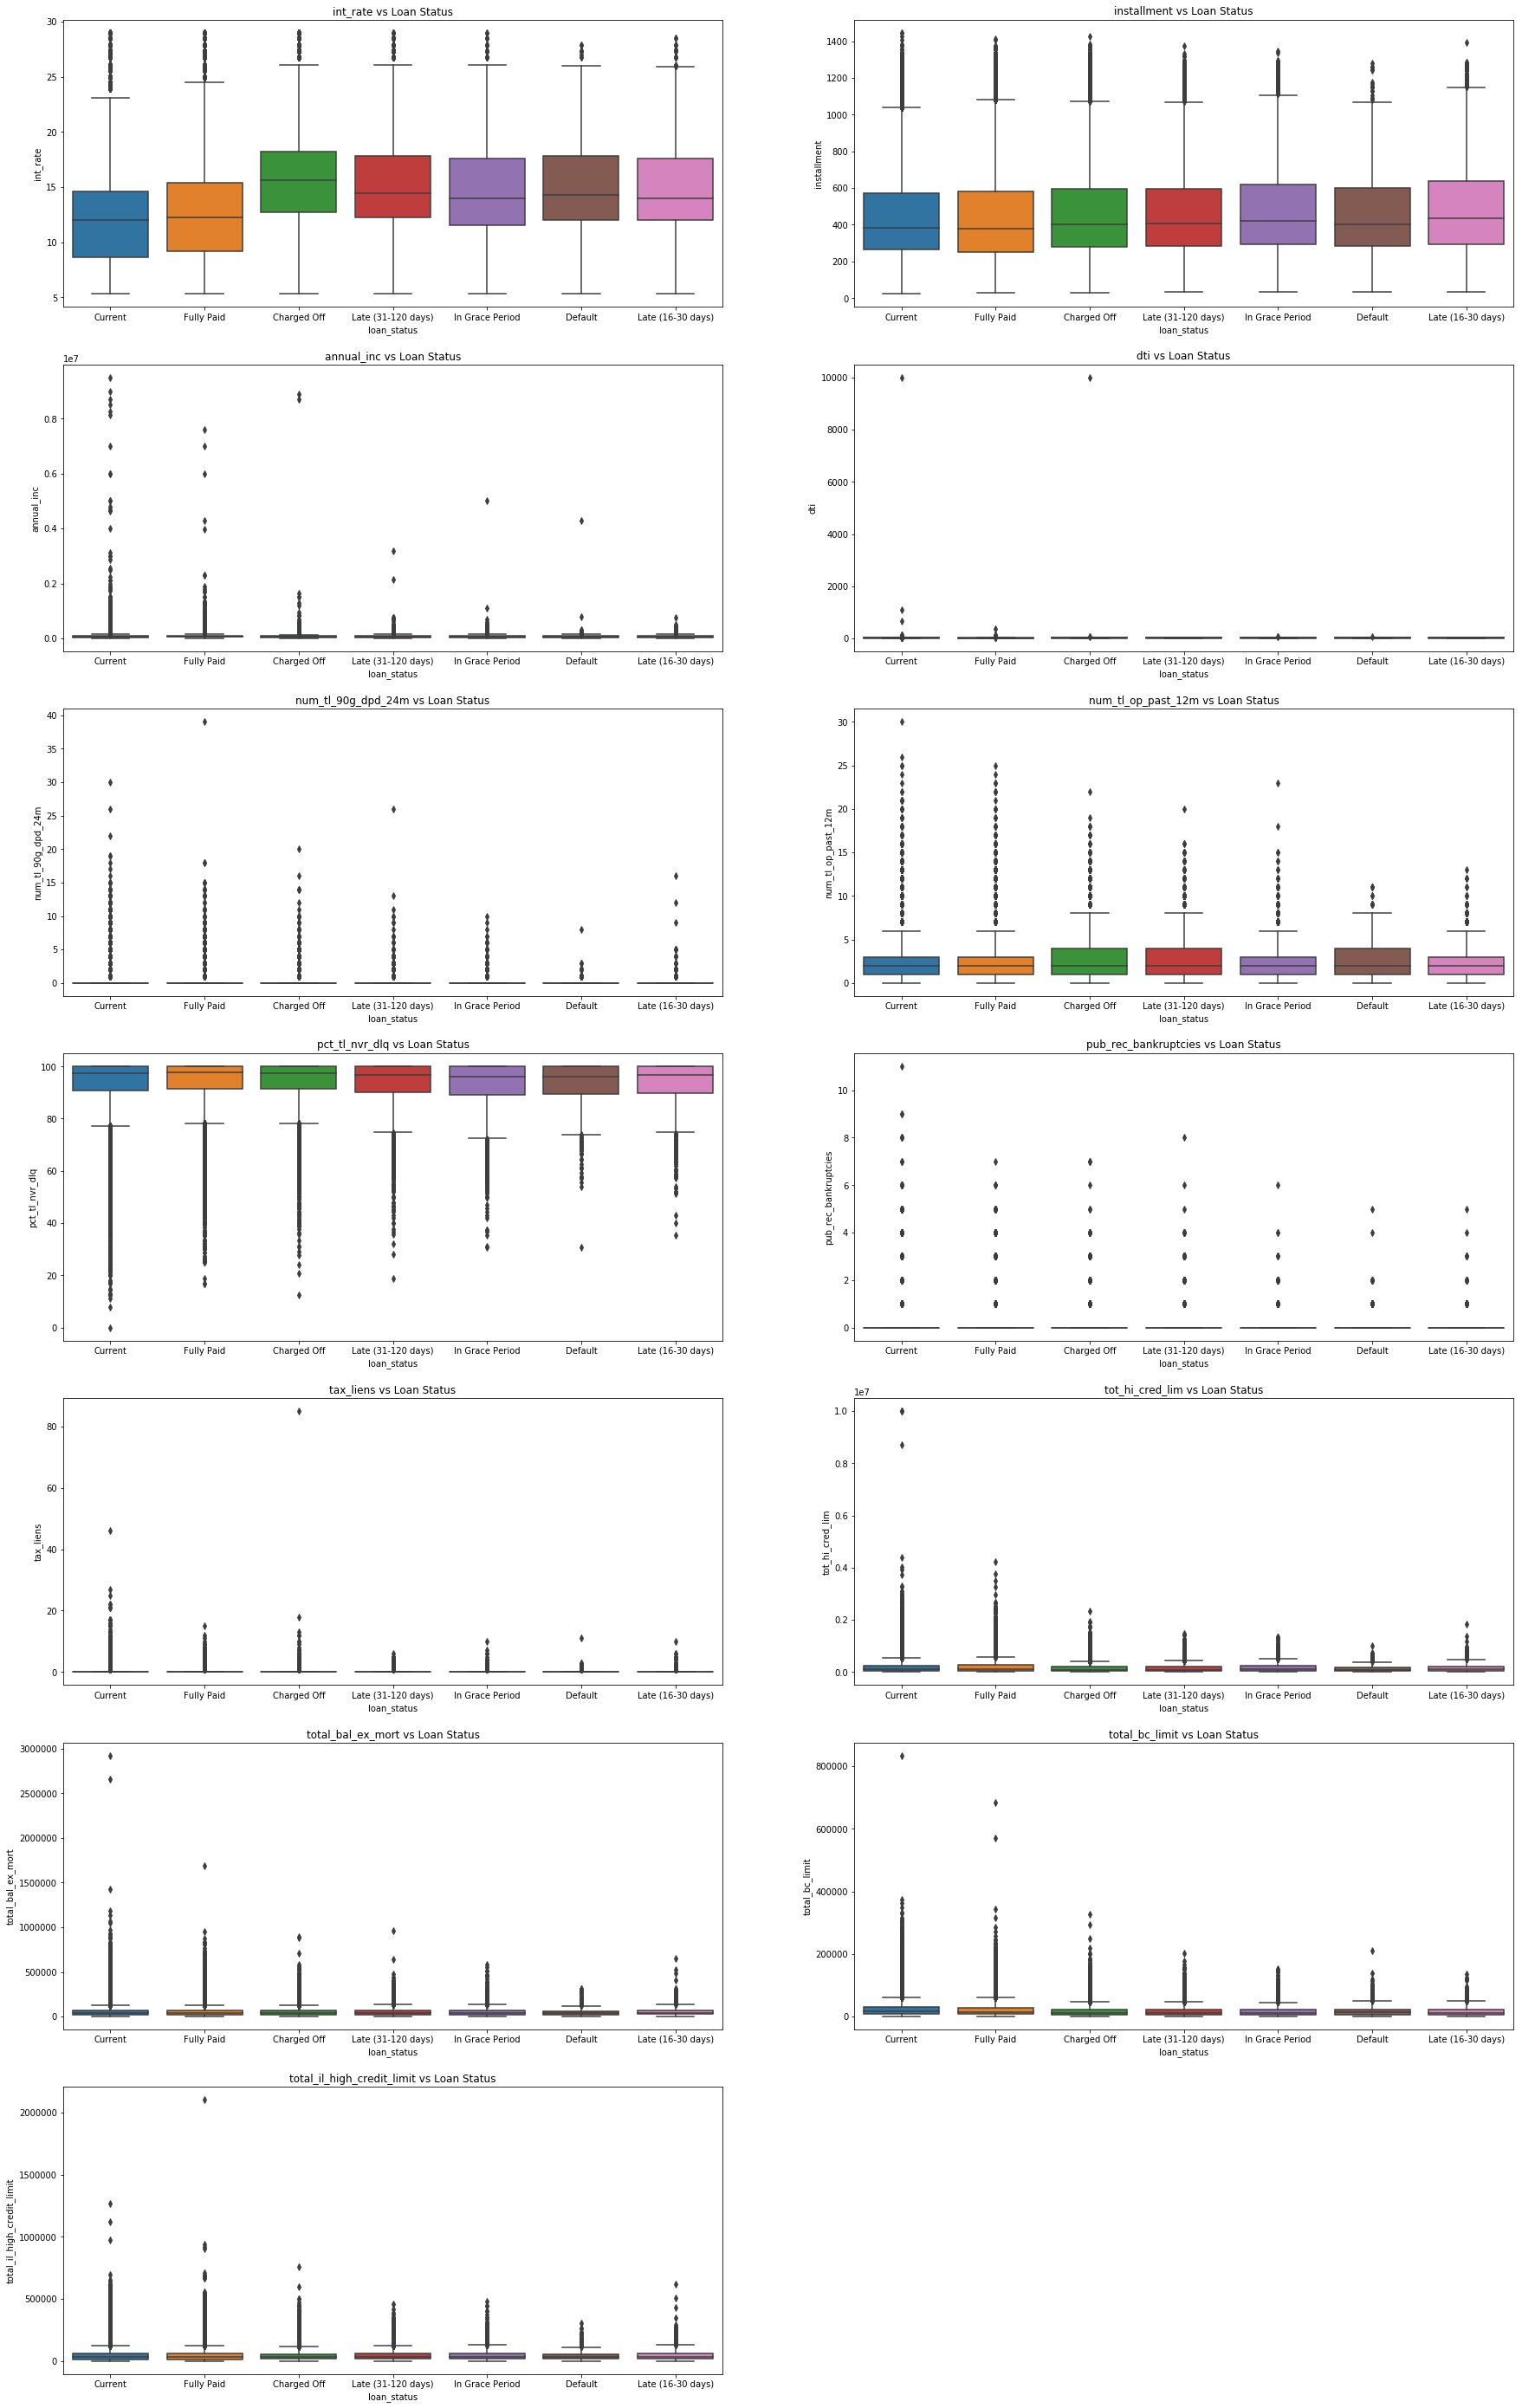

In [9]:
#plotting continuous variables versus loan status to determine correlations
plt.figure(figsize=(30,50))
i=0
for col in df_cont:
    i+=1
    plt.subplot(7,2,i)
    sns.boxplot(x=y2015['loan_status'], y=col, data=df_cont)
    plt.title('{} vs Loan Status'.format(col))
    
plt.show()

It appears that there are a number of outliers that are skewing the data. Need to remove outliers in order to better fit data.

In [10]:
#removing outliers for each column
for col in df_cont.columns:
    median = df_cont[col].median()
    std = df_cont[col].std()
    out_high = median + 2*std
    out_low = median - 2*std
    df_cont[col] = df_cont[col].map(lambda x: x if x < out_high and x > out_low else None)

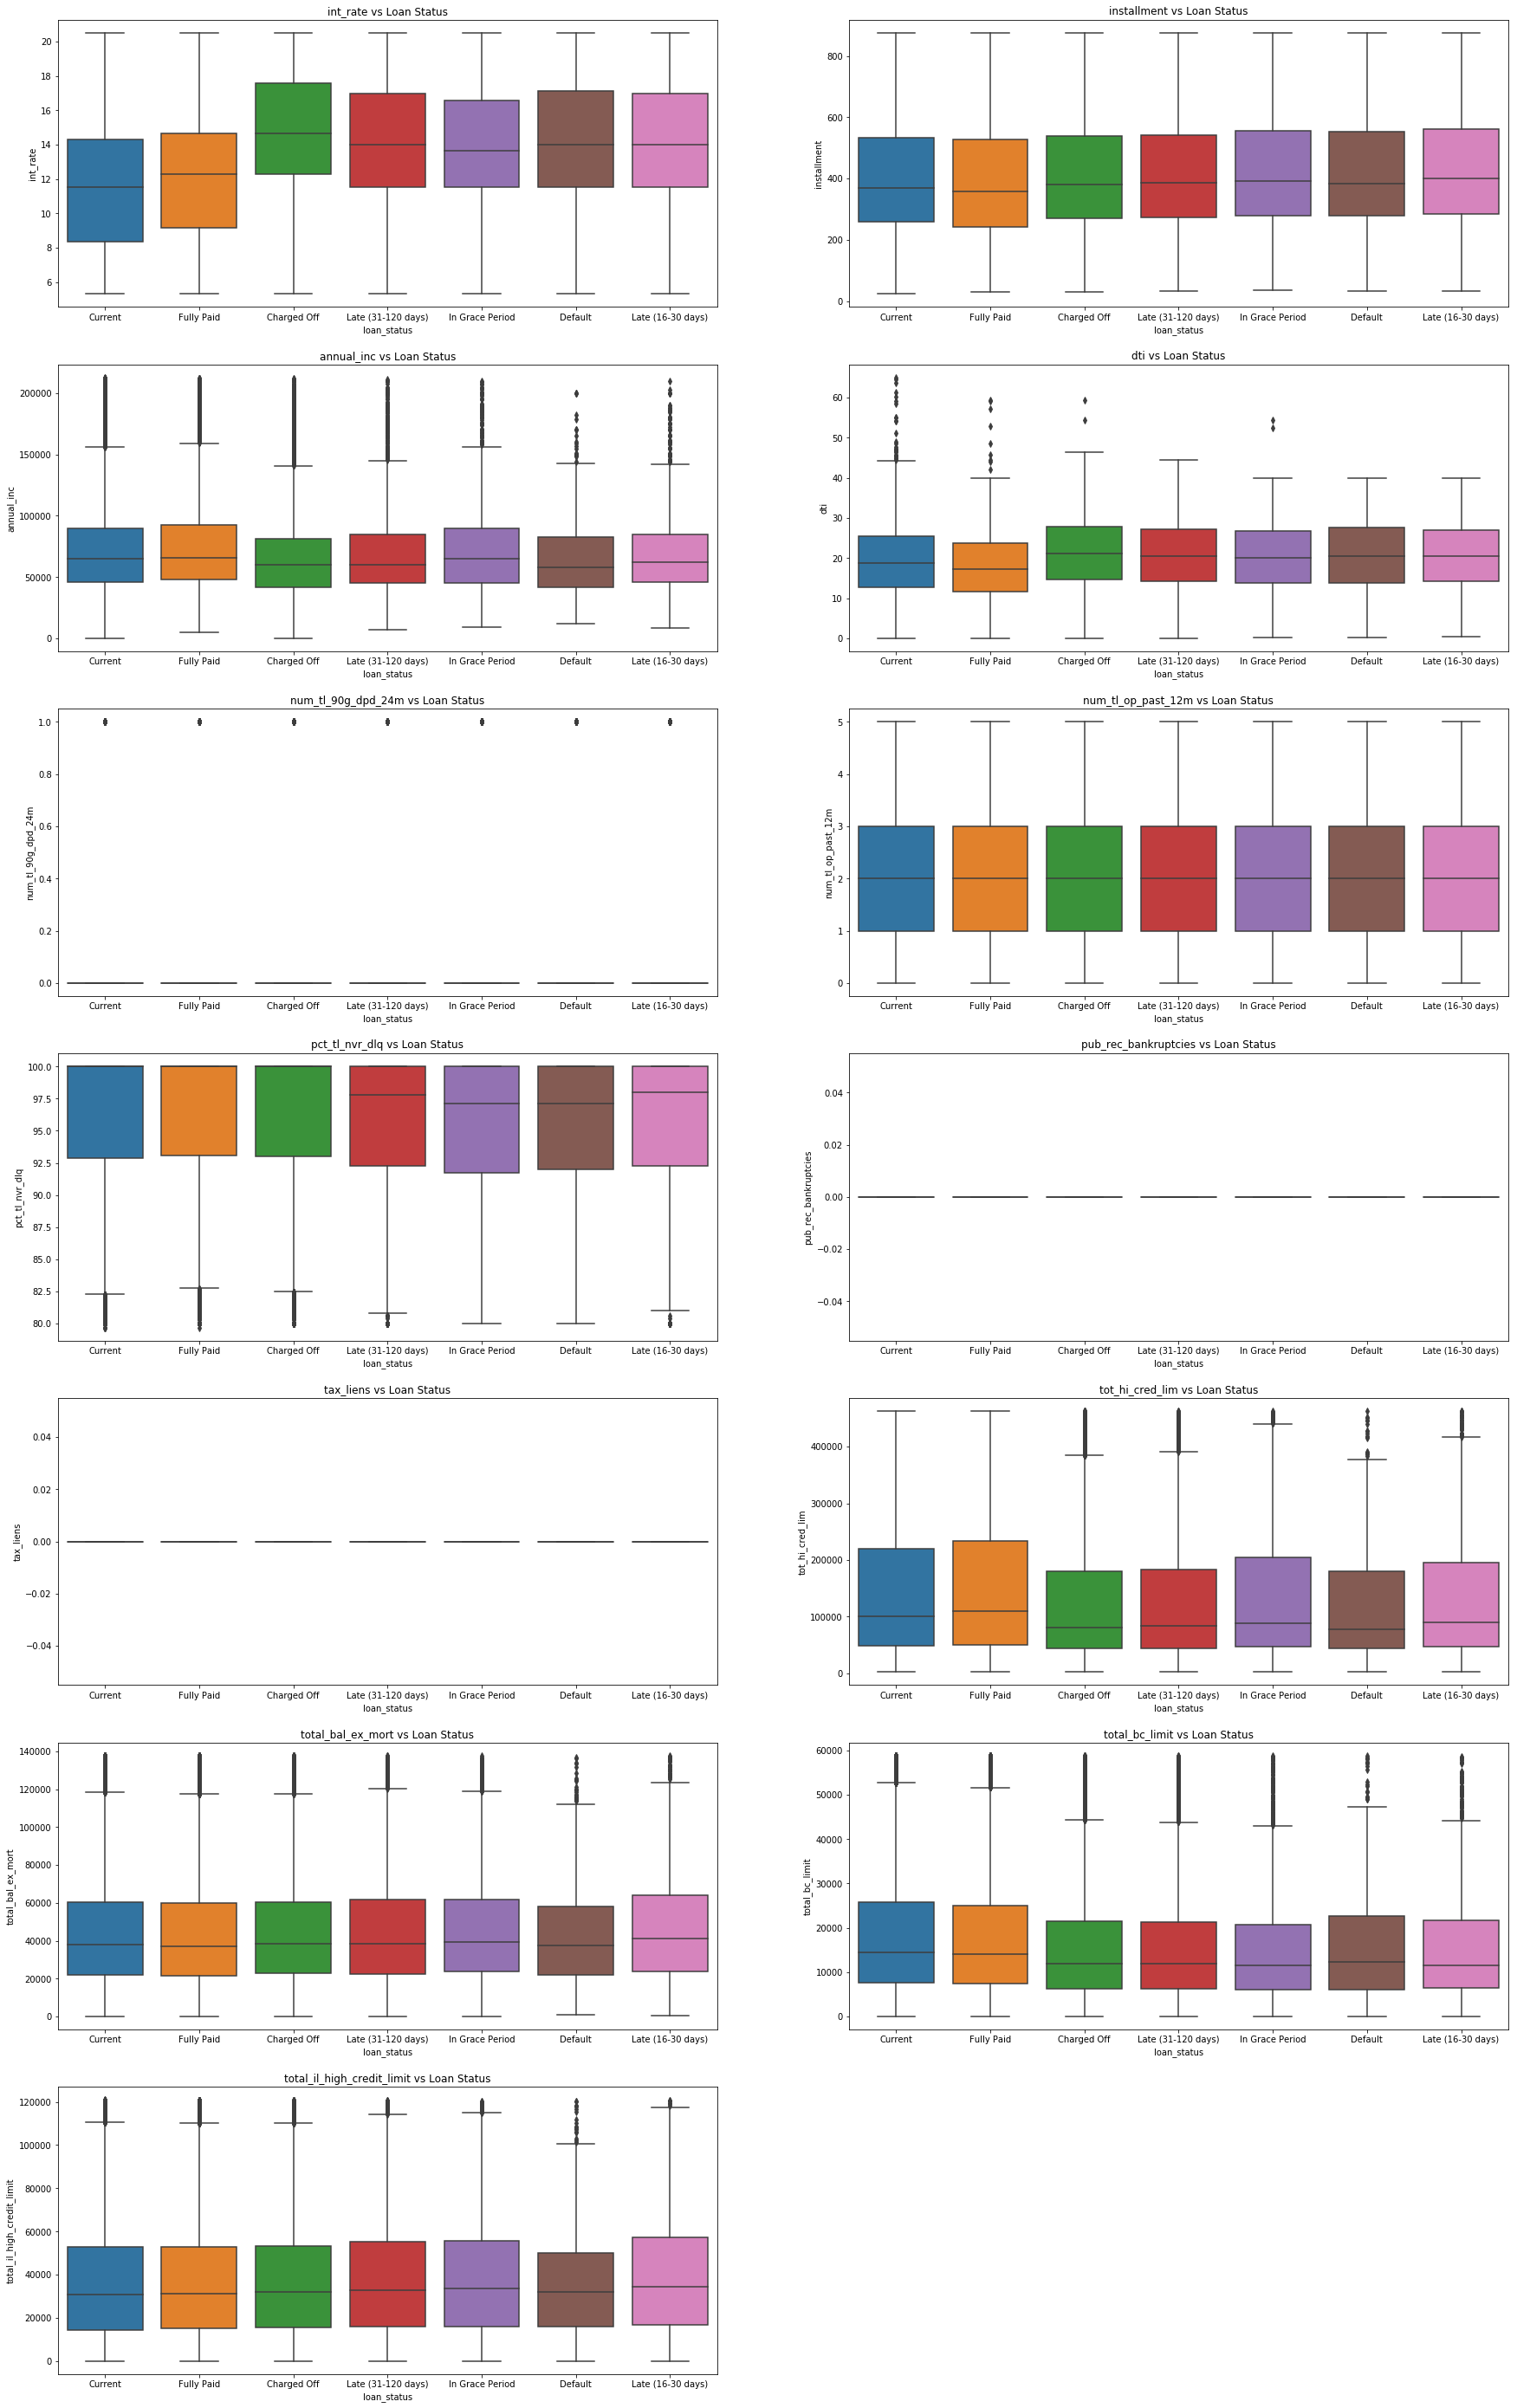

In [11]:
#re-plotting to determine correlations
plt.figure(figsize=(30,50))
i=0
for col in df_cont:
    i+=1
    plt.subplot(7,2,i)
    sns.boxplot(x=y2015['loan_status'], y=col, data=df_cont)
    plt.title('{} vs Loan Status'.format(col))
    
plt.show()

Most of these are too close to determine significant differences between the variable and loan status.  Complete t-test to determine significance.

In [12]:
#running t-tests between default and current status of loan versus all continuous variables
for col in df_cont.columns:
    print('\n', col)
    print(ttest_ind(
        df_cont[y2015['loan_status']=='Default'][col].dropna(),
        df_cont[y2015['loan_status']=='Current'][col].dropna()))


 int_rate
Ttest_indResult(statistic=16.063015051762775, pvalue=4.920812572815696e-58)

 installment
Ttest_indResult(statistic=1.8833829266132776, pvalue=0.05964956031465667)

 annual_inc
Ttest_indResult(statistic=-4.879864407928302, pvalue=1.0621646943035269e-06)

 dti
Ttest_indResult(statistic=5.362798213818211, pvalue=8.20053763385522e-08)

 num_tl_90g_dpd_24m
Ttest_indResult(statistic=0.10564546244933244, pvalue=0.9158637274076885)

 num_tl_op_past_12m
Ttest_indResult(statistic=9.164972946516903, pvalue=4.988388229226611e-20)

 pct_tl_nvr_dlq
Ttest_indResult(statistic=-2.8941587761661416, pvalue=0.0038020685779569068)

 pub_rec_bankruptcies
Ttest_indResult(statistic=nan, pvalue=nan)

 tax_liens
Ttest_indResult(statistic=nan, pvalue=nan)

 tot_hi_cred_lim
Ttest_indResult(statistic=-5.02938286761033, pvalue=4.923749162214416e-07)

 total_bal_ex_mort
Ttest_indResult(statistic=-0.8637059610666186, pvalue=0.38775019584128256)

 total_bc_limit
Ttest_indResult(statistic=-5.061412685212496

The p-values that are significant under p-values of 0.05, will be used as features in our new Random Forest Classifier model. 

Constructing the features below

In [13]:
#assembling features of significance against same Y.
Y = y2015['loan_status']
X3 = pd.DataFrame(df_cont.loc[:, ['int_rate', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 
                                  'total_bc_limit', 'pct_tl_nvr_dlq', 'dti', 'annual_inc']].dropna())
X3.head()

,int_rate,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,pct_tl_nvr_dlq,dti,annual_inc
1,7.49,2.0,88635.0,12500.0,100.0,22.44,60000.0
2,7.49,0.0,373572.0,38400.0,100.0,26.02,109000.0
3,6.49,0.0,304003.0,41500.0,91.7,21.60,92000.0
5,8.49,2.0,93962.0,39500.0,87.9,18.28,64000.0
6,12.88,4.0,271700.0,34000.0,100.0,21.77,65000.0


In [14]:
#assembling model and running cross validation score
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X3, Y, cv=5)

ValueError: Found input variables with inconsistent numbers of samples: [312706, 421095]

How do I remove the same entries of Loan Status as I did with outliers? Initially I added Loan Status to the y_cont Data Frame, but then it threw a bunch of errors because Loan Status is not continuous, so I removed it.  How to I keep it but avoid errors?

In [15]:
#inspecting one entry to identify categorical variables
y2015.iloc[0]

id                                            6.80094e+07
member_id                                     7.28681e+07
loan_amnt                                           16000
funded_amnt                                         16000
funded_amnt_inv                                     16000
term                                            60 months
int_rate                                            14.85
installment                                        379.39
grade                                                   C
emp_length                                      10+ years
home_ownership                                   MORTGAGE
annual_inc                                          48000
verification_status                          Not Verified
issue_d                                          Dec-2015
loan_status                                       Current
pymnt_plan                                              n
purpose                                       credit_card
title         

In [16]:
#utilizing categorical variables to analyze for relationship to loan status
df_cat = y2015.loc[:, ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 
                       'pymnt_plan', 'purpose', 'initial_list_status']]
df_cat.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,initial_list_status
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,w
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,w
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,w
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,w
4,36 months,E,8 years,RENT,Verified,Dec-2015,n,debt_consolidation,w


In [17]:
#Creating counttable for each variable and then performing chisquare test to determine significance
for col in df_cat.columns:
    counttable = pd.crosstab(y2015['loan_status'], df_cat[col])
    print('\n', col)
    print(counttable)
    print(chisquare(counttable, axis=None))


 term
term                 36 months   60 months
loan_status                               
Charged Off              16962       12216
Current                 190905       96509
Default                    465         331
Fully Paid               65375       22614
In Grace Period           2678        1642
Late (16-30 days)         1125         763
Late (31-120 days)        5663        3847
Power_divergenceResult(statistic=1275808.9367886106, pvalue=0.0)

 grade
grade                   A      B      C      D      E     F    G
loan_status                                                     
Charged Off          1211   4392   8533   7153   5206  2101  582
Current             55348  85572  81545  38911  20353  4819  866
Default                39    159    236    173    129    49   11
Fully Paid          15886  24524  25178  12904   6939  2036  522
In Grace Period       269    866   1441    972    545   184   43
Late (16-30 days)      94    365    618    420    269   101   21
Late (31-120 

Most of the pvalues of the chi square tests are 0.0.  Is this another example of highly significant? Or why are they mostly all 0.0?

In [18]:
#assuming significance of all variables, turning into continuous by getting dummies and assigning features
X4 = df_cat
Y = y2015['loan_status']
X4 = pd.get_dummies(X4)
X4 = X4.dropna(axis=1)

In [19]:
#running model with categorical dummies
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X4, Y, cv=5)

array([0.66952423, 0.26700309, 0.21587509, 0.23230188, 0.36637931])

Cross validation scores are low and all over the place.  I need to combine both categorical and continuous variables into same data frame to score.